In [4]:
import time
import random
from zipfile import ZipFile

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Compose, ToTensor, Resize


from PIL import Image

from sklearn.metrics import f1_score   

# Important variables

In [5]:
DATA_PATH = "/content/data/"
batch_size = 32
epochs = 20
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 83% 89.0M/107M [00:00<00:00, 137MB/s]
100% 107M/107M [00:00<00:00, 142MB/s] 


In [7]:
with ZipFile("flood-area-segmentation.zip") as f:
    f.extractall(DATA_PATH)

# Data processing

In [8]:
class DS(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.meta = pd.read_csv(DATA_PATH + "metadata.csv")
        self.meta.drop(index=[0,2, 151], inplace=True)

        self.meta = self.meta[:250] if train else self.meta[250:] # Separate the data for train/test stages

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):

        def pil_loader(path):
            with open(path, 'rb') as f:
                with Image.open(f) as img:
                    return img.convert("RGB")

        img = pil_loader(DATA_PATH + "Image/" + self.meta.iloc[idx]["Image"])
        mask = Image.open(DATA_PATH + "Mask/" + self.meta.iloc[idx]["Mask"])
        
        transformed_image = self.transform(img)
        transformed_mask = self.transform(mask)
        
        return transformed_image, transformed_mask

In [9]:
train_ds = DS(transform=Compose([Resize(size=(188, 188)), ToTensor()]))
test_ds = DS(transform=Compose([Resize(size=(188, 188)), ToTensor()]), train=False)

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size, drop_last=True)

# Training

In [38]:
def train_model(model, model_name, dataloaders: list, loss_fn, optim, scheduler, metrics: dict, epochs=epochs):
    model = model.to(device)
    
    best_loss = 1e10
    metric_name = list(metrics.keys())[0]
    metric = list(metrics.values())[0]
    since = time.time()
    dataloaders = {"Train": dataloaders[0], "Test": dataloaders[1]}

    model_results = {"Train": {"Loss": [], metric_name: []}, "Test": {"Loss": [], metric_name: []}} # Create dict to represent model results at the end 

    for epoch in range(epochs):
        print(f"======= Epoch {epoch+1} =======")
        train_epoch_loss = 0.0
        test_epoch_loss = 0.0
        train_metric_val = []
        test_metric_val = []

        #### Train ####

        model.train()

        for batch, (X, y) in enumerate(dataloaders["Train"]):
            X, y = X.to(device), y.to(device)

            optim.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = loss_fn(outputs, y)

                y_pred = outputs.data.cpu().numpy().ravel()
                y = y.data.cpu().numpy().ravel()
                train_metric_val.append(metric(y > 0, y_pred > 0.1)) # Add metric results to final model results

                
                loss.backward()
                optim.step()

                train_epoch_loss += loss.item()
        train_epoch_loss /= batch

        if loss < best_loss:
            best_loss = loss
            best_model_wts = model.state_dict()


        #### Test ####

        model.eval()

        for batch, (X, y) in enumerate(dataloaders["Test"]):
            X, y = X.to(device), y.to(device)

            optim.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(X)
                loss = loss_fn(outputs, y)

                y_pred = outputs.data.cpu().numpy().ravel()
                y = y.data.cpu().numpy().ravel()
                test_metric_val.append(metric(y > 0, y_pred > 0.1)) # Add metric results to final model results


                test_epoch_loss += loss.item()


        model_results["Train"]["Loss"].append(train_epoch_loss)
        model_results["Train"][metric_name].append(np.mean(train_metric_val))

        model_results["Test"]["Loss"].append(test_epoch_loss)
        model_results["Test"][metric_name].append(np.mean(test_metric_val))

        print('Train Loss: {:.4f}'.format(train_epoch_loss))
        print('Train F1-score: {:.4f}'.format(np.mean(train_metric_val)))
        print()
        print('Test Loss: {:.4f}'.format(test_epoch_loss))
        print('Test F1-score: {:.4f}'.format(np.mean(test_metric_val)))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f"Model state saved with the best loss: {best_loss:.4f}")

    torch.save(best_model_wts, f"{model_name}_{best_loss:.4f}.pt")
    

    return model_results     

In [39]:
def compare_imgs(model, img, mask):
    """ 
    Show three images: Original img, its mask and model prediction. 
    Accepts:
    :model;
    :img in Tensor format;
    :mask in Tensor format;
    """
    model.eval()
    pred = model(img.to(device).unsqueeze(0))
    img, pred = to_pil_image(img.squeeze()), to_pil_image(pred.squeeze())

    _, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(img)
    ax[0].set_title("Original image")
    ax[1].imshow(mask.squeeze())
    ax[1].set_title("Mask")
    ax[2].imshow(pred)
    ax[2].set_title("Model's prediction")
    plt.show()

In [40]:
def show_results(model_results, model_name):
    train = model_results["Train"]
    test = model_results["Test"]
    metric = list(model_results["Train"].keys())[1]
    epoch_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.title(model_name)
    for phase in ["Train", "Test"]:
        data = train if phase == "Train" else test
        plt.plot(epoch_range, data["Loss"], label=f"{phase}_loss")
        plt.plot(epoch_range, data[metric], label=f"{phase}_{metric}")
    
    plt.legend()
    plt.show()

# Model

In [41]:
class Segm_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.enc4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), bias=False),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.conv = nn.Conv2d(32, 1, kernel_size=(1, 1))
        self.sigm = nn.Sigmoid()

    
    def forward(self, x):
        pool = self.pool

        enc1 = self.enc1(x)
        enc2 = self.enc2(pool(enc1))
        enc3 = self.enc3(pool(enc2))
        enc4 = self.enc4(pool(enc3))

        b = self.bottleneck(pool(enc4))

        dec1 = self.dec1(b) + enc4
        dec2 = self.dec2(dec1) + enc3
        dec3 = self.dec3(dec2) + enc2
        dec4 = self.dec4(dec3) + enc1

        mask = self.sigm(self.conv(dec4))

        return mask

In [42]:
model = Segm_model().to(device)

In [43]:
model_name = "Autoencoder"
dataloaders = [train_dl, test_dl]
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
metrics = {"f1-score": f1_score}

In [ ]:
results = train_model(model, model_name, dataloaders, loss_fn, optim, scheduler, metrics, epochs)

# Model results

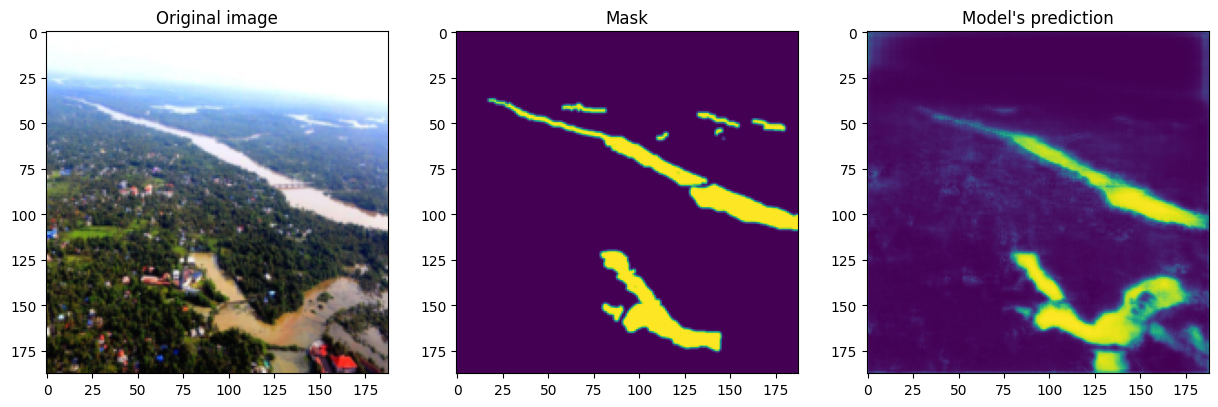

In [46]:
img, mask = test_ds[random.randint(0, len(test_ds)-1)]
compare_imgs(model, img, mask)

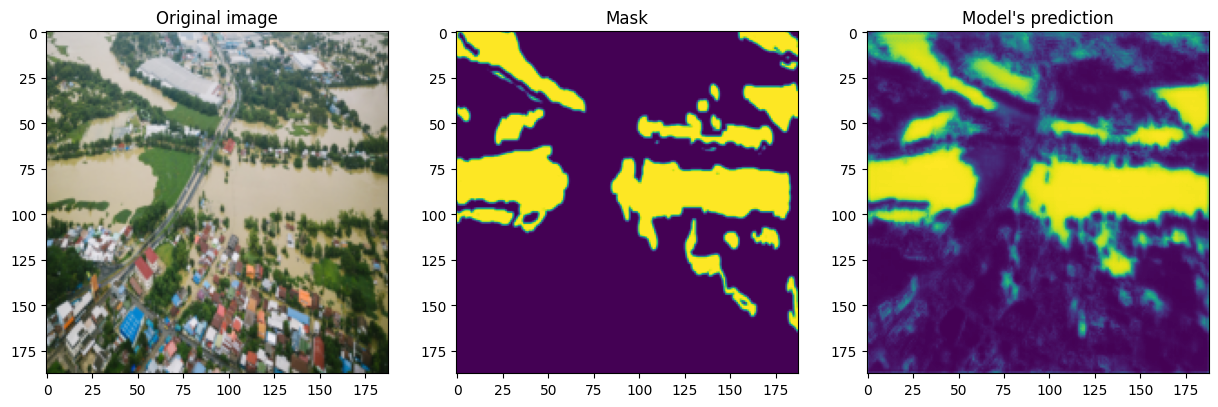

In [47]:
img, mask = test_ds[random.randint(0, len(test_ds)-1)]
compare_imgs(model, img, mask)

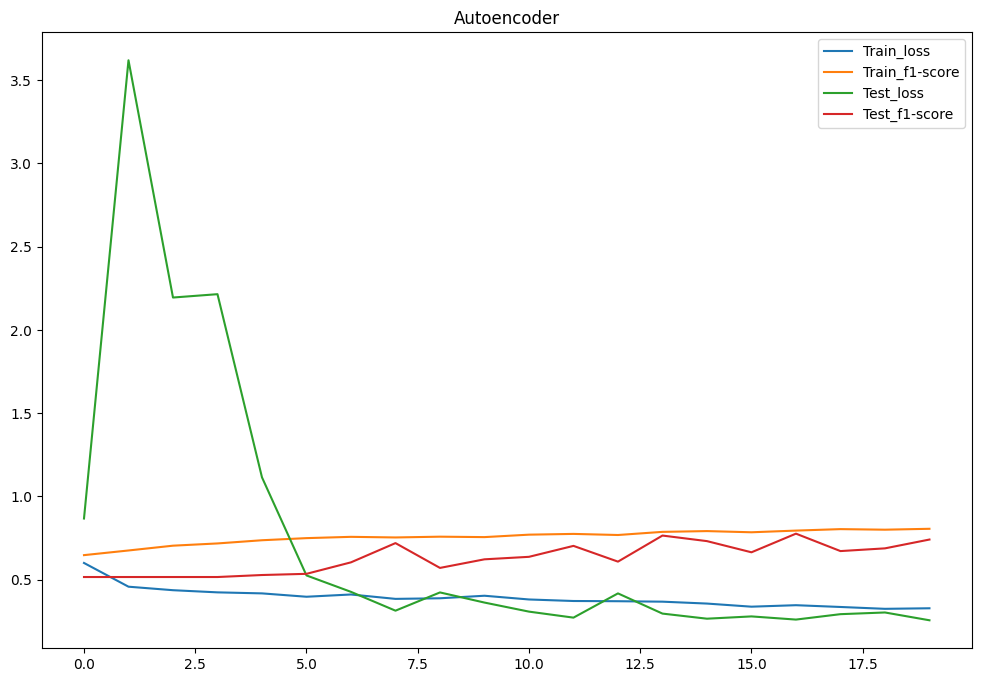

In [48]:
show_results(results, model_name)